# Inicio

In [1]:
import os, sys, time
import pandas as pd
import numpy as np
import math 
from statistics import variance 
import statsmodels.api as sm
from IPython.display import display, HTML

#Visualization
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
import plotly
import plotly.express as px

import warnings 
warnings.filterwarnings("ignore")

In [955]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.linear_model import LinearRegression
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, classification_report, accuracy_score, confusion_matrix

In [5]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('max_colwidth', 1000) # tamanho das colunas para exibição do conteúdo de textos longos
np.set_printoptions(threshold=1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
sns.set(style="darkgrid") #cor da area dos plots
figsize = (10,10)

# Funcoes

## Criar Matriz de Confusão

In [516]:
def create_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # Plotar a matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['PBZ', 'BR', 'ASM'],  
            yticklabels=['PBZ', 'BR', 'ASM'])  
    plt.title('Matriz de Confusão')
    plt.xlabel('Prevista')
    plt.ylabel('Real')
    plt.show()

## Obter as variaveis mais importantes

In [540]:
def get_feature_importances(model):
    feature_importances = model.get_feature_importance(prettified=True)
    top_10_var_predictors = list(feature_importances['Feature Id'][0:10].values)
    display(feature_importances.head(10))
    
    ax = feature_importances.plot(kind='bar', figsize=(10, 6))
    plt.title('Top 10 Feature Importances', fontsize=16, pad=10)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    ax.set_xticklabels(feature_importances['Feature Id'], rotation=90)
    plt.tight_layout()  
    plt.show()
    
    return top_10_var_predictors

In [559]:
def get_feature_importances_RF(model, X):
    importances = model.feature_importances_ 
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances})
    
    top_10_var_predictors = feature_importances.sort_values(by='Importance', ascending=False).head(10)
    display(top_10_var_predictors)
    
    ax = feature_importances.sort_values(by='Importance', ascending=False)[0:20].plot(kind='bar', 
                                                                                      x='Feature',
                                                                                      y='Importance',
                                                                                      figsize=(15, 10))
    plt.title('Top 20 Feature Importances', fontsize=16, pad=10)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.tight_layout()  
    plt.show()
    
    return list(top_10_var_predictors['Feature'].values)

# Coleta dos dados

## Carregar dados familias

In [865]:
%%time
dict_dtype = {'cd_ibge':'str',
              'uf_ibge':'str',
              #'regiao_ibge':'str',
              'id_familia':'str'}

df_fam_orig = pd.read_csv('./dados_preparados/df_familia_final_preparado.csv',
                     dtype=dict_dtype,
                     sep='|', 
                     low_memory=False)

df_fam = df_fam_orig.copy()
#df_fam.info()

CPU times: total: 1.16 s
Wall time: 1.16 s


## Separação lista colunas

In [842]:
# 'cd_ibge', 'uf_ibge', 'nome_uf_ibge',
# ind_parc_mds_fam
l_col_id = ['id_familia']
l_col_target_num = ['vlr_renda_media_fam']
l_col_target_cat = ['classe_renda', 'cod_faixa_renda', 'nom_faixa_renda']

l_col_num = ['qtd_comodos_domic_fam', 'qtd_comodos_dormitorio_fam',
             'dias_cadastramento', 'dias_atualizacao', 'qtde_pessoas']
l_col_num_scaled = ['qtd_comodos_domic_fam_scaled', 'qtd_comodos_dormitorio_fam_scaled',
                    'dias_cadastramento_scaled', 'dias_atualizacao_scaled',
                    'qtde_pessoas_scaled']

l_col_cat_num = ['uf_ibge', 'regiao_ibge', 'classf', 
             'cod_local_domic_fam', 'cod_especie_domic_fam',
             'cod_material_piso_fam', 'cod_material_domic_fam',
             'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam',
             'cod_banheiro_domic_fam', 'cod_escoa_sanitario_domic_fam',
             'cod_destino_lixo_domic_fam', 'cod_iluminacao_domic_fam',
             'cod_calcamento_domic_fam'] 

l_col_cat_nomes = ['nome_uf_ibge','nome_regiao_ibge', 'nome_classf', 
                   'nome_local_domic_fam', 'nome_especie_domic_fam', 
                   'nome_material_piso_fam', 'nome_material_domic_fam', 
                   'nome_agua_canalizada_fam', 'nome_abaste_agua_domic_fam', 
                   'nome_banheiro_domic_fam', 'nome_escoa_sanitario_domic_fam', 
                   'nome_destino_lixo_domic_fam', 'nome_iluminacao_domic_fam', 
                   'nome_calcamento_domic_fam']

l_col_cat_num_outras = ['estrato',
                    'cod_familia_indigena_fam',
                    'ind_familia_quilombola_fam',
                    'ind_parc_mds_fam']

l_col_cat_nomes_simpl = ['nome_banh_escoa', 'nome_agua_abaste', 
                         'nome_dest_lixo_simpl', 'nome_iluminacao_simpl',
                         'nome_material_piso_simpl', 'nome_material_domic_simpl',
                         'ind_grp_especifico', 'ind_grp_especial']

l_col_cat_faixas = ['faixa_comodos_domic_fam', 'faixa_comodos_dormitorio_fam', 'faixa_qtde_pessoas']

# Pre processamento

## Converter atributos num_categoricos para string 

In [867]:
for c in l_col_cat_num:
    df_fam[c] = df_fam[c].astype(str)

for c in l_col_cat_num_outras:
    df_fam[c] = df_fam[c].astype(str)

## Padronizar atributos numéricos

In [868]:
scaler = StandardScaler()
df_fam_scaled = pd.DataFrame(scaler.fit_transform(df_fam[l_col_num]),
                             columns=[f'{col}_scaled' for col in l_col_num])

df_fam = pd.concat([df_fam, df_fam_scaled], axis=1)
print('Atributos normalizados:\n', df_fam_scaled.columns.values )

Atributos normalizados:
 ['qtd_comodos_domic_fam_scaled' 'qtd_comodos_dormitorio_fam_scaled'
 'dias_cadastramento_scaled' 'dias_atualizacao_scaled'
 'qtde_pessoas_scaled']


## Converter campos nome para Categóricos

In [869]:
lista_nomes = l_col_cat_nomes + l_col_cat_num_outras + l_col_cat_nomes_simpl + l_col_cat_faixas
lista_nomes_encoded = [nome + '_encoded' for nome in lista_nomes]

In [870]:
label_encoders = {}
label_mappings = {}

for col in lista_nomes:
    encoder = LabelEncoder()
    df_fam[f'{col}_encoded'] = encoder.fit_transform(df_fam[col])
    label_encoders[col] = encoder
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [871]:
label_encoders_2 = {}
label_mappings_2 = {}

encoder_2 = OneHotEncoder(sparse=False)

for col in lista_nomes:
    one_hot_encoded = encoder_2.fit_transform(df_fam[[col]])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=[f'{col}_{category}' for category in encoder_2.categories_[0]])
    df_fam = pd.concat([df_fam, one_hot_encoded_df], axis=1)
    label_encoders_2[col] = encoder_2
    label_mappings_2[col] = dict(zip(encoder_2.categories_[0], range(len(encoder_2.categories_[0]))))

#df_fam.columns[88:].values

In [872]:
#checar
#df_fam[lista_nomes_encoded].info()
col_int =['nome_banh_escoa','nome_banh_escoa_encoded','faixa_qtde_pessoas','faixa_qtde_pessoas_encoded']
df_fam[col_int].head(5)

,nome_banh_escoa,nome_banh_escoa_encoded,faixa_qtde_pessoas,faixa_qtde_pessoas_encoded
0,Com banheiro/ fossa rudimentar,1,>= 4 pessoas,3
1,Com banheiro/ fossa rudimentar,1,2 pessoas,1
2,Com banheiro/ rede coletora,3,2 pessoas,1
3,Com banheiro/ rede coletora,3,2 pessoas,1
4,Com banheiro/ rede coletora,3,1 pessoa,0


# Preparar planilha metricas

In [496]:
col_int = ['model_name', 'learning_rate', 'loss_function', 'test_size', 'depth',
           'random_seed', 'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details', 'param']
            #'var_predictors', 'top_10_var_predictors', 
df_metrics[col_int].sort_values(by='accuracy', ascending=False).head(5)

,model_name,learning_rate,loss_function,test_size,depth,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details,param
5,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.2000,6,42,0.6712,0.5981,0.5436,0.5408,0.6403,0.6712,0.6331,"Todas variaveis, inclusive UF",na
4,CatBoostClassifier,0.1000,MultiClass,0.2000,6,42,0.6702,0.5962,0.5454,0.5417,0.6399,0.6702,0.6333,"Todas variaveis, inclusive UF",na
12,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.1500,6,42,0.6696,0.5963,0.5416,0.5377,0.6395,0.6696,0.6311,"Todas variaveis, inclusive UF","{'iterations': 1000, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MultiClassOneVsAll', 'random_seed': 42, 'verbose': 100, 'eval_metric': 'Accuracy'}"
1,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.2000,6,42,0.6676,0.5924,0.5391,0.5353,0.6354,0.6676,0.6286,"Todas variaveis, exceto UF",na
0,CatBoostClassifier,0.1000,MultiClass,0.2000,6,42,0.6667,0.5923,0.5392,0.5354,0.6355,0.6667,0.6283,"Todas variaveis, exceto UF",na


# CatBoost Classifier

## Parametros

In [358]:
model_name='CatBoostClassifier'
iterations=1000
learning_rate=0.1
depth=6 
loss_function=  'MultiClassOneVsAll' #'MultiClassOneVsAll' #'MultiClass'
test_size=0.2
random_seed=42
details='Todas variaveis, inclusive UF' 
param='na'

## Setar variaveis preditoras e target 

In [344]:
# usar as variaveis sem LabelEncoder/ OneHot Encoding
var_predictors='l_col_num_scaled, l_col_cat_nomes, l_col_cat_num_outras, l_col_cat_nomes_simpl, l_col_cat_faixas'
X = pd.concat([
        df_fam[l_col_num_scaled],
        df_fam[l_col_cat_nomes],
        df_fam[l_col_cat_num_outras],
        df_fam[l_col_cat_nomes_simpl],
        df_fam[l_col_cat_faixas],
            ], axis=1) 
categorical_features = list(X.columns[5:].values)

In [323]:
#most_important_var = ['qtde_pessoas_scaled',
#                      'dias_atualizacao_scaled',  'dias_cadastramento_scaled', 
#                      'faixa_qtde_pessoas', 
#                      'nome_regiao_ibge',  'nome_uf_ibge', 
#                      'qtd_comodos_domic_fam_scaled', 
#                      'nome_material_piso_simpl', 
#                      'faixa_comodos_domic_fam', 'nome_classf']

#var_predictors = most_important_var
#X = df_fam[most_important_var]
#categorical_features = ['faixa_qtde_pessoas', 'nome_regiao_ibge', 'nome_uf_ibge',
#                        'nome_material_piso_simpl', 'faixa_comodos_domic_fam', 'nome_classf']

#y = df_fam['classe_renda']

## Dividir os dados em conjuntos de treino e teste

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_seed)

In [346]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

## Treinar o modelo

In [347]:
%%time
model = CatBoostClassifier(
    iterations=iterations,
    learning_rate=learning_rate,
    depth=depth,
    loss_function=loss_function,
    eval_metric='Accuracy',
    verbose=100,
    random_seed=random_seed)

model.fit(train_pool, 
          eval_set=test_pool, 
          early_stopping_rounds=50)

params = model.get_params()

0:	learn: 0.6225953	test: 0.6251036	best: 0.6251036 (0)	total: 466ms	remaining: 7m 45s
100:	learn: 0.6620462	test: 0.6631666	best: 0.6633048 (97)	total: 49.2s	remaining: 7m 18s
200:	learn: 0.6697754	test: 0.6659298	best: 0.6662061 (196)	total: 1m 37s	remaining: 6m 27s
300:	learn: 0.6733962	test: 0.6691075	best: 0.6694529 (295)	total: 2m 26s	remaining: 5m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6695910473
bestIteration = 311

Shrink model to first 312 iterations.
CPU times: total: 18min 14s
Wall time: 2min 55s


## Avaliar o modelo

### Classification Report

In [348]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extrair as métricas 
rpt_accuracy = report['accuracy']
rpt_macro_avg = report['macro avg']
rpt_weighted_avg = report['weighted avg']

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6695910472506217
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.79      8582
           1       0.50      0.16      0.25      3079
           2       0.58      0.58      0.58      2815

    accuracy                           0.67     14476
   macro avg       0.60      0.54      0.54     14476
weighted avg       0.64      0.67      0.63     14476



### Matriz Confusão

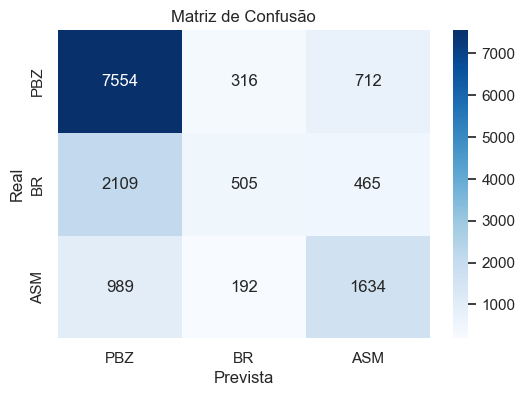

In [349]:
create_confusion_matrix(y_test, y_pred)

### Features mais importantes

,Feature Id,Importances
0,qtde_pessoas_scaled,17.3009
1,faixa_qtde_pessoas,15.9022
2,dias_cadastramento_scaled,11.6229
3,dias_atualizacao_scaled,11.1230
4,nome_regiao_ibge,8.6084
5,nome_uf_ibge,5.7728
6,faixa_comodos_domic_fam,4.9524
7,qtd_comodos_domic_fam_scaled,3.8655
8,nome_material_piso_simpl,3.4542
9,nome_classf,2.7001


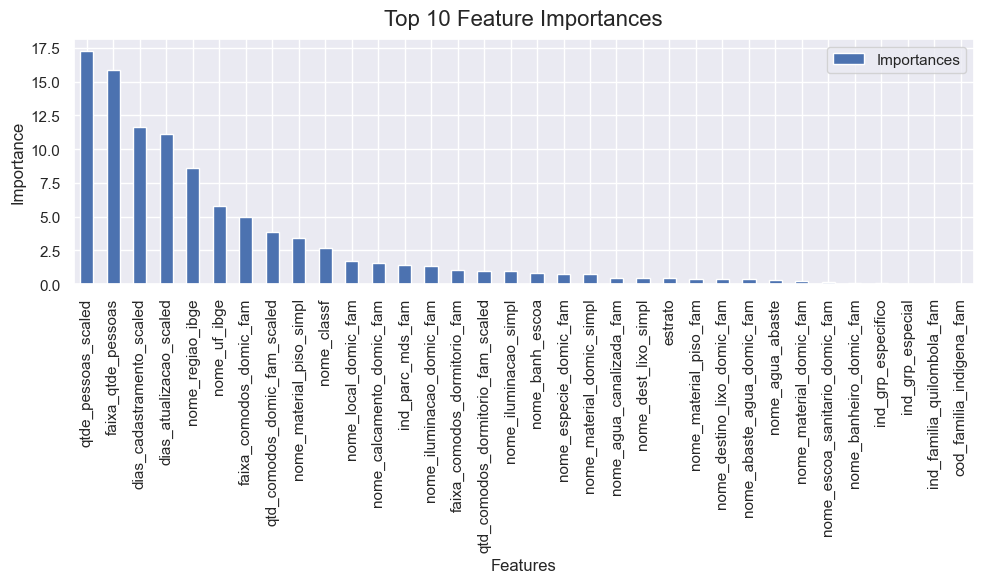

In [350]:
top_10_var_predictors = get_feature_importances(model)

## Salvar na planilha de metricas

In [359]:
result = {
    'model_name': model_name,
    'learning_rate': learning_rate,
    'loss_function':loss_function,
    'test_size': test_size,
    'depth': depth,
    'random_seed': random_seed,
    'accuracy': acc_score, 
    'm_precision': rpt_macro_avg['precision'], 
    'm_recall': rpt_macro_avg['recall'], 
    'm_f1_score': rpt_macro_avg['f1-score'],
    'w_precision': rpt_weighted_avg['precision'], 
    'w_recall': rpt_weighted_avg['recall'], 
    'w_f1_score': rpt_weighted_avg['f1-score'],
    'var_predictors': var_predictors,
    'top_10_var_predictors':top_10_var_predictors,
    'details': details,
    'param': params}
df_metrics = pd.concat([df_metrics, pd.DataFrame([result])], ignore_index=True)

In [362]:
col_int = ['model_name', 'learning_rate', 'loss_function', 'test_size', 'depth',
           'random_seed', 'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details']
            #'var_predictors', 'top_10_var_predictors', 

#df_metrics[col_int].sort_values(by='accuracy', ascending=False).head(10)
df_metrics[df_metrics['model_name']=='CatBoostClassifier'][col_int].sort_values(by='accuracy', ascending=False).head(10)

,model_name,learning_rate,loss_function,test_size,depth,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details
5,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.2000,6,42,0.6712,0.5981,0.5436,0.5408,0.6403,0.6712,0.6331,"Todas variaveis, inclusive UF"
4,CatBoostClassifier,0.1000,MultiClass,0.2000,6,42,0.6702,0.5962,0.5454,0.5417,0.6399,0.6702,0.6333,"Todas variaveis, inclusive UF"
12,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.1500,6,42,0.6696,0.5963,0.5416,0.5377,0.6395,0.6696,0.6311,"Todas variaveis, inclusive UF"
1,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.2000,6,42,0.6676,0.5924,0.5391,0.5353,0.6354,0.6676,0.6286,"Todas variaveis, exceto UF"
0,CatBoostClassifier,0.1000,MultiClass,0.2000,6,42,0.6667,0.5923,0.5392,0.5354,0.6355,0.6667,0.6283,"Todas variaveis, exceto UF"
11,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.2000,6,42,0.6653,0.5923,0.5325,0.5284,0.6330,0.6653,0.6235,Top 10 most important variables
2,CatBoostClassifier,0.1000,MultiClass,0.2000,8,42,0.6649,0.5865,0.5363,0.5317,0.6315,0.6649,0.6258,"Todas variaveis, exceto UF"
3,CatBoostClassifier,0.1000,MultiClassOneVsAll,0.2000,8,42,0.6636,0.5846,0.5333,0.5284,0.6295,0.6636,0.6235,"Todas variaveis, exceto UF"


In [339]:
#df_metrics.to_csv('./dados_metricas/df_metrics_domicilio.csv', encoding='UTF-8',  sep='|',  index=False)

# KNeighbors Classifier

## Parametros

In [235]:
model_name='KNeighbors Classifier'
n_neighbors = 7
test_size=0.2
random_seed=42
details='Todas variaveis, inclusive UF' 

## Setar variaveis preditoras e target 

In [236]:
var_predictors='l_col_num_scaled, lista_nomes_encoded'

# todas as var. preditoras sao numericas
X = pd.concat([
        df_fam[l_col_num_scaled],
        df_fam[lista_nomes_encoded],
        ], axis=1) 
y = df_fam['classe_renda']

## Dividir os dados em conjuntos de treino e teste

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_seed)

## Treinar o modelo

In [239]:
model = KNeighborsClassifier(n_neighbors=n_neighbors)
model.fit(X_train, y_train)
params = model.get_params()
predictions = model.predict(X_test)

## Avaliar o modelo

### Classification Report

In [240]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extrair as métricas 
rpt_accuracy = report['accuracy']
rpt_macro_avg = report['macro avg']
rpt_weighted_avg = report['weighted avg']

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6218330656442671
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.84      0.75     11424
           1       0.35      0.19      0.25      4090
           2       0.55      0.44      0.49      3787

    accuracy                           0.62     19301
   macro avg       0.53      0.49      0.50     19301
weighted avg       0.59      0.62      0.59     19301



### Matriz Confusão

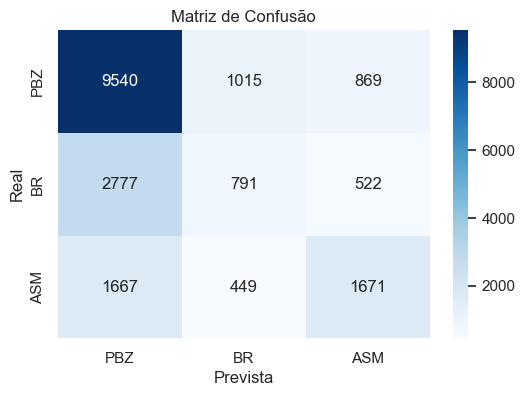

In [241]:
create_confusion_matrix(y_test, y_pred)

## Salvar na planilha de metricas

In [242]:
result = {
    'model_name': model_name,
    'learning_rate': 'na',
    'loss_function':'na',
    'test_size': test_size,
    'depth': 'na',
    'random_seed': random_seed,
    'accuracy': acc_score, 
    'm_precision': rpt_macro_avg['precision'], 
    'm_recall': rpt_macro_avg['recall'], 
    'm_f1_score': rpt_macro_avg['f1-score'],
    'w_precision': rpt_weighted_avg['precision'], 
    'w_recall': rpt_weighted_avg['recall'], 
    'w_f1_score': rpt_weighted_avg['f1-score'],
    'var_predictors': var_predictors,
    'top_10_var_predictors':'na',
    'details': details,
    'param':params}
df_metrics = pd.concat([df_metrics, pd.DataFrame([result])], ignore_index=True)

In [246]:
col_int = ['model_name', 'test_size', 
           'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details', 'param']
            
df_metrics[df_metrics['model_name']=='KNeighbors Classifier'][col_int]\
            .sort_values(by='accuracy', ascending=False)

,model_name,test_size,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details,param
8,KNeighbors Classifier,0.2000,0.6218,0.5262,0.4899,0.4961,0.5852,0.6218,0.5930,"Todas variaveis, inclusive UF","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}"
7,KNeighbors Classifier,0.2000,0.6093,0.5150,0.4769,0.4859,0.5763,0.6093,0.5840,"Todas variaveis, inclusive UF","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}"
6,KNeighbors Classifier,0.2000,0.5945,0.4996,0.4736,0.4798,0.5642,0.5945,0.5732,"Todas variaveis, inclusive UF","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}"


In [247]:
#df_metrics.to_csv('./dados_metricas/df_metrics_domicilio.csv', encoding='UTF-8',  sep='|',  index=False)

# Logistic Regression

## Parametros

In [386]:
model_name='Logistic Regression'
test_size=0.2
random_seed=42
solver='saga' #lbfgs
details='Todas variaveis, inclusive UF' 
penalty='l2'

## Setar variaveis preditoras e target 

In [375]:
var_predictors='l_col_num_scaled, lista_nomes_encoded'

# todas as var. preditoras sao numericas
X = pd.concat([
        df_fam[l_col_num_scaled],
        df_fam[lista_nomes_encoded],
        ], axis=1) 
y = df_fam['classe_renda']

## Dividir os dados em conjuntos de treino e teste

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_seed)

## Treinar o modelo

In [380]:
model = LogisticRegression(multi_class='multinomial', 
                           solver=solver, 
                           max_iter=1000,
                          penalty=penalty)
model.fit(X_train, y_train)
params = model.get_params()
predictions = model.predict(X_test)

## Avaliar o modelo

### Classification Report

In [381]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extrair as métricas 
rpt_accuracy = report['accuracy']
rpt_macro_avg = report['macro avg']
rpt_weighted_avg = report['weighted avg']

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6405885705403865
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.76     11424
           1       0.45      0.06      0.10      4090
           2       0.55      0.51      0.53      3787

    accuracy                           0.64     19301
   macro avg       0.55      0.49      0.46     19301
weighted avg       0.60      0.64      0.58     19301



### Matriz Confusão

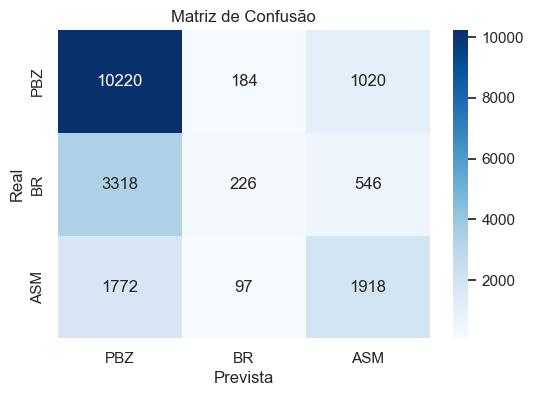

In [299]:
create_confusion_matrix(y_test, y_pred)

## Salvar na planilha de metricas

In [382]:
result = {
    'model_name': model_name,
    'learning_rate': 'na',
    'loss_function':'na',
    'test_size': test_size,
    'depth': 'na',
    'random_seed': random_seed,
    'accuracy': acc_score, 
    'm_precision': rpt_macro_avg['precision'], 
    'm_recall': rpt_macro_avg['recall'], 
    'm_f1_score': rpt_macro_avg['f1-score'],
    'w_precision': rpt_weighted_avg['precision'], 
    'w_recall': rpt_weighted_avg['recall'], 
    'w_f1_score': rpt_weighted_avg['f1-score'],
    'var_predictors': var_predictors,
    'top_10_var_predictors':'na',
    'details': details,
    'param':params}
df_metrics = pd.concat([df_metrics, pd.DataFrame([result])], ignore_index=True)

In [387]:
col_int = ['model_name', 'test_size', 'random_seed',
           'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details', 'param']

df_metrics[df_metrics['model_name']=='Logistic Regression'][col_int]\
            .sort_values(by='accuracy', ascending=False)

,model_name,test_size,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details,param
10,Logistic Regression,0.2000,42,0.6406,0.5546,0.4854,0.4635,0.5976,0.6406,0.5769,"Todas variaveis, inclusive UF","{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}"
13,Logistic Regression,0.2000,42,0.6406,0.5546,0.4854,0.4635,0.5976,0.6406,0.5769,"Todas variaveis, inclusive UF","{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}"
9,Logistic Regression,0.2000,42,0.6404,0.5547,0.4854,0.4634,0.5976,0.6404,0.5767,"Todas variaveis, inclusive UF","{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}"


In [306]:
#df_metrics.to_csv('./dados_metricas/df_metrics_domicilio.csv', encoding='UTF-8',  sep='|',  index=False)

# Random Forest Classifier

## Parametros

In [584]:
model_name='Random Forest'
test_size=0.2
random_seed=42
n_estimators = 100
criterion= 'log_loss' #'gini' #entropy # log_loss
max_depth = 50
details='Todas variaveis, inclusive UF' 

## Setar variaveis preditoras e target 

In [508]:
lista_nomes_encoded_2 = df_fam.columns[88:].values
#lista_nomes_encoded_2

In [566]:
var_predictors='l_col_num_scaled, lista_nomes_encoded_2'

X = pd.concat([
        df_fam[l_col_num_scaled],
        df_fam[lista_nomes_encoded_2],
        ], axis=1) 
y = df_fam['classe_renda']

## Dividir os dados em conjuntos de treino e teste

In [585]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_seed)

## Treinar o modelo

In [586]:
%%time
model = RandomForestClassifier(n_estimators=n_estimators, 
                               criterion=criterion,
                               max_depth=max_depth,
                               random_state=42)

model.fit(X_train, y_train)
params = model.get_params()
predictions = model.predict(X_test)

CPU times: total: 22.7 s
Wall time: 23.2 s


## Avaliar o modelo

### Classification Report

In [587]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extrair as métricas 
rpt_accuracy = report['accuracy']
rpt_macro_avg = report['macro avg']
rpt_weighted_avg = report['weighted avg']

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6369618154499767
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76     11424
           1       0.39      0.21      0.27      4090
           2       0.55      0.51      0.53      3787

    accuracy                           0.64     19301
   macro avg       0.55      0.52      0.52     19301
weighted avg       0.60      0.64      0.61     19301



### Matriz Confusão

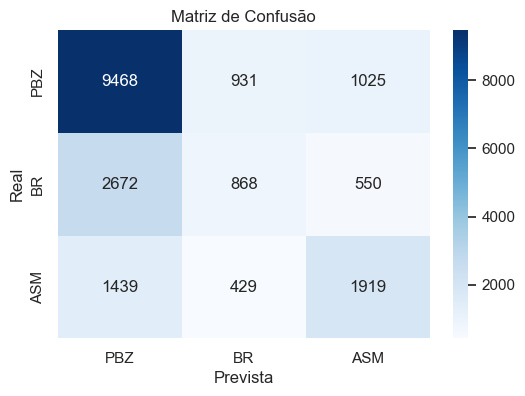

In [442]:
create_confusion_matrix(y_test, y_pred)

### Features mais importantes

,Feature,Importance
4,qtde_pessoas_scaled,0.0828
48,nome_material_piso_fam_Ceram_laj_pedra,0.0821
33,nome_regiao_ibge_Nordeste,0.0481
40,nome_local_domic_fam_Nao se aplica,0.0401
99,nome_calcamento_domic_fam_Total,0.0238
0,qtd_comodos_domic_fam_scaled,0.0199
42,nome_local_domic_fam_Urbanas,0.0181
90,nome_iluminacao_domic_fam_Eletrica - med. proprio,0.0174
35,nome_regiao_ibge_Sudeste,0.0158
118,ind_parc_mds_fam_306,0.0140


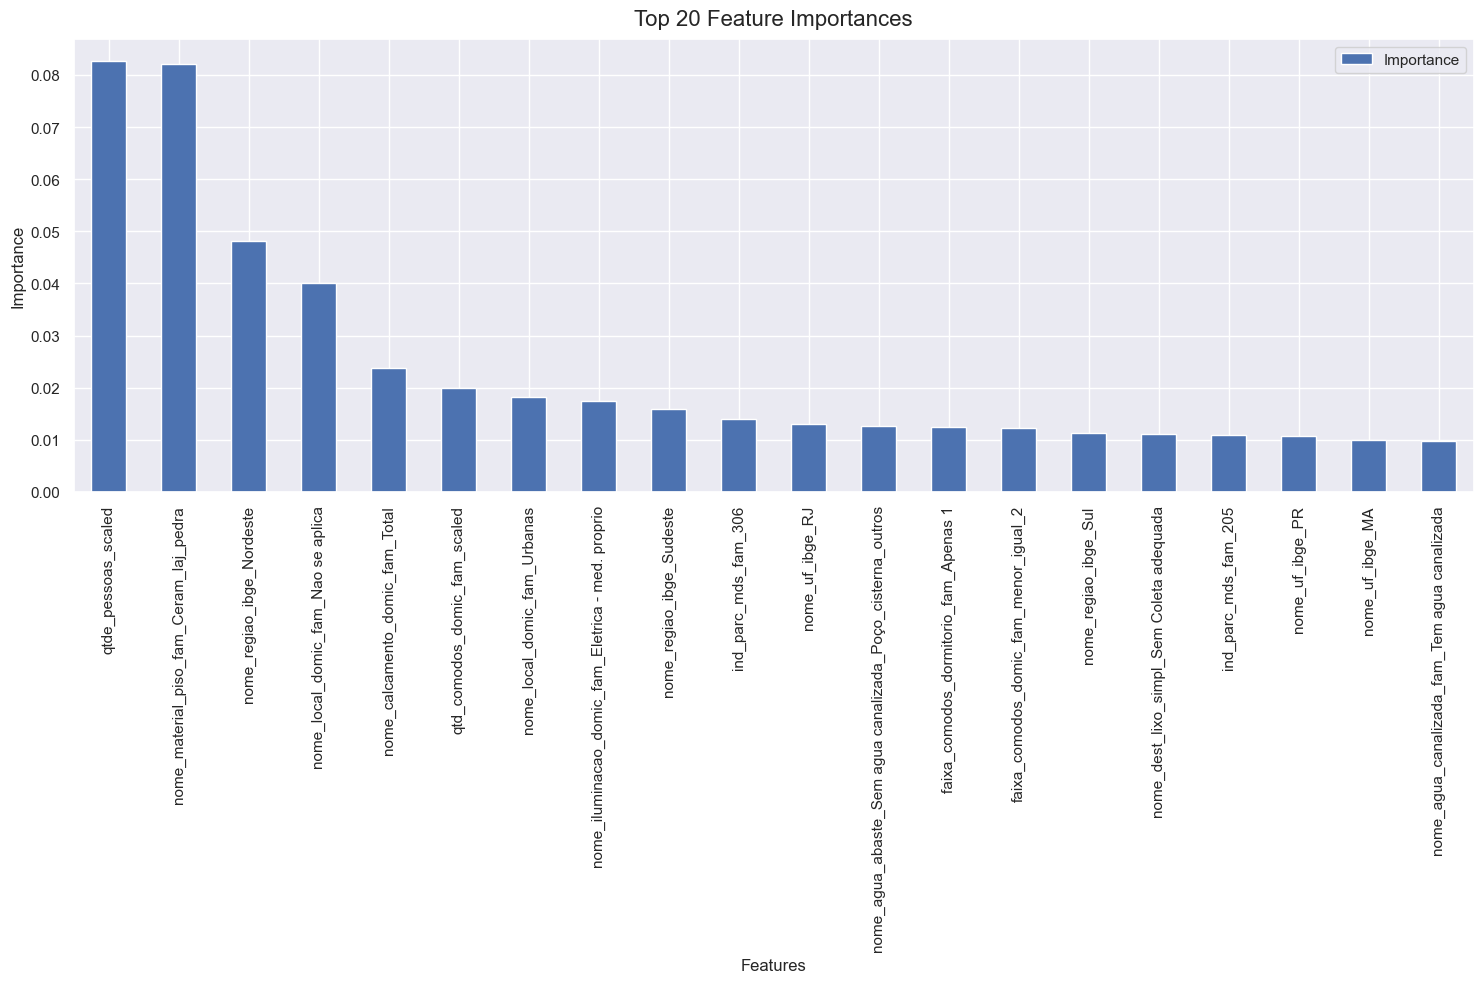

In [953]:
top_10_var_predictors = get_feature_importances_RF(model, X)

## Salvar na planilha de metricas

In [ ]:
result = {
    'model_name': model_name,
    'learning_rate': 'na',
    'loss_function':'na',
    'test_size': test_size,
    'depth': 'na',
    'random_seed': random_seed,
    'accuracy': acc_score, 
    'm_precision': rpt_macro_avg['precision'], 
    'm_recall': rpt_macro_avg['recall'], 
    'm_f1_score': rpt_macro_avg['f1-score'],
    'w_precision': rpt_weighted_avg['precision'], 
    'w_recall': rpt_weighted_avg['recall'], 
    'w_f1_score': rpt_weighted_avg['f1-score'],
    'var_predictors': var_predictors,
    'top_10_var_predictors': top_10_var_predictors,
    'details': details,
    'param':params}

df_metrics = pd.concat([df_metrics, pd.DataFrame([result])], ignore_index=True)

In [591]:
col_int = ['model_name', 'test_size', 'random_seed',
           'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details', 'param']

#col_int = ['accuracy','top_10_var_predictors']

df_metrics[df_metrics['model_name']=='Random Forest'][col_int]\
            .sort_values(by='accuracy', ascending=False)

,model_name,test_size,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details,param
16,Random Forest,0.2000,42,0.6440,0.5726,0.4713,0.4504,0.6032,0.6440,0.5695,"Todas variaveis, inclusive UF","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"
15,Random Forest,0.2000,42,0.6382,0.5478,0.5172,0.5205,0.6048,0.6382,0.6115,"Todas variaveis, inclusive UF","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"
18,Random Forest,0.2000,42,0.6370,0.5463,0.5158,0.5196,0.6038,0.6370,0.6109,"Todas variaveis, inclusive UF","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"
19,Random Forest,0.2000,42,0.6370,0.5463,0.5158,0.5196,0.6038,0.6370,0.6109,"Todas variaveis, inclusive UF","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"
17,Random Forest,0.2000,42,0.6367,0.5466,0.5160,0.5199,0.6036,0.6367,0.6106,"Todas variaveis, inclusive UF","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}"


In [592]:
#df_metrics.to_csv('./dados_metricas/df_metrics_domicilio.csv', encoding='UTF-8',  sep='|',  index=False)

# Decision Tree Classifiers

## Parametros

In [878]:
model_name='Decision Tree'
test_size=0.2
max_depth=5
criterion='gini' #entropy #log_loss #gini
max_features=None
random_seed=42
#details='Todas variaveis, exceto UF' 
details='Todas variaveis, exceto UF e grupos especificos' 

## Setar variaveis preditoras e target 

In [879]:
#lista_nomes_encoded_2 = df_fam.columns[88:].values # inclui UF
#lista_nomes_encoded_2 = df_fam.columns[115:].values # inclui UF

# exclui UF, 
#cod_familia_indigena_fam, ind_familia_quilombola_fam, ind_parc_mds_fam
lista_nomes_p1 = list(df_fam.columns[115:185].values)
lista_nomes_p2 = list(df_fam.columns[204:].values)
lista_nomes_tree = lista_nomes_p1 + lista_nomes_p2
#lista_nomes_tree

In [880]:
var_predictors='l_col_num_scaled, lista_nomes_tree'

X = pd.concat([
        df_fam[l_col_num_scaled],
        df_fam[lista_nomes_tree],
        ], axis=1) 
y = df_fam['classe_renda']

## Dividir os dados em conjuntos de treino e teste

In [883]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_seed)

## Treinar o modelo

In [884]:
model = DecisionTreeClassifier(random_state=random_state, 
                               max_depth=max_depth,
                               criterion=criterion,
                               max_features=max_features)

model.fit(X_train, y_train)
params = model.get_params()
predictions = model.predict(X_test)

## Avaliar o modelo

### Classification Report

In [885]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extrair as métricas 
rpt_accuracy = report['accuracy']
rpt_macro_avg = report['macro avg']
rpt_weighted_avg = report['weighted avg']

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6410548676234392
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.90      0.76     11424
           1       0.45      0.07      0.12      4090
           2       0.58      0.49      0.53      3787

    accuracy                           0.64     19301
   macro avg       0.56      0.49      0.47     19301
weighted avg       0.60      0.64      0.58     19301



### Matriz Confusão

In [505]:
create_confusion_matrix(y_test, y_pred)

### Features mais importantes

,Feature,Importance
4,qtde_pessoas_scaled,0.5210
21,nome_material_piso_fam_Ceram_laj_pedra,0.1612
0,qtd_comodos_domic_fam_scaled,0.0639
6,nome_regiao_ibge_Nordeste,0.0631
2,dias_cadastramento_scaled,0.0521
93,nome_material_piso_simpl_Ceram_laj_pedra,0.0510
3,dias_atualizacao_scaled,0.0364
17,nome_especie_domic_fam_Não se aplica,0.0191
119,faixa_qtde_pessoas_2 pessoas,0.0158
77,nome_banh_escoa_Com banheiro/ rede coletora,0.0080


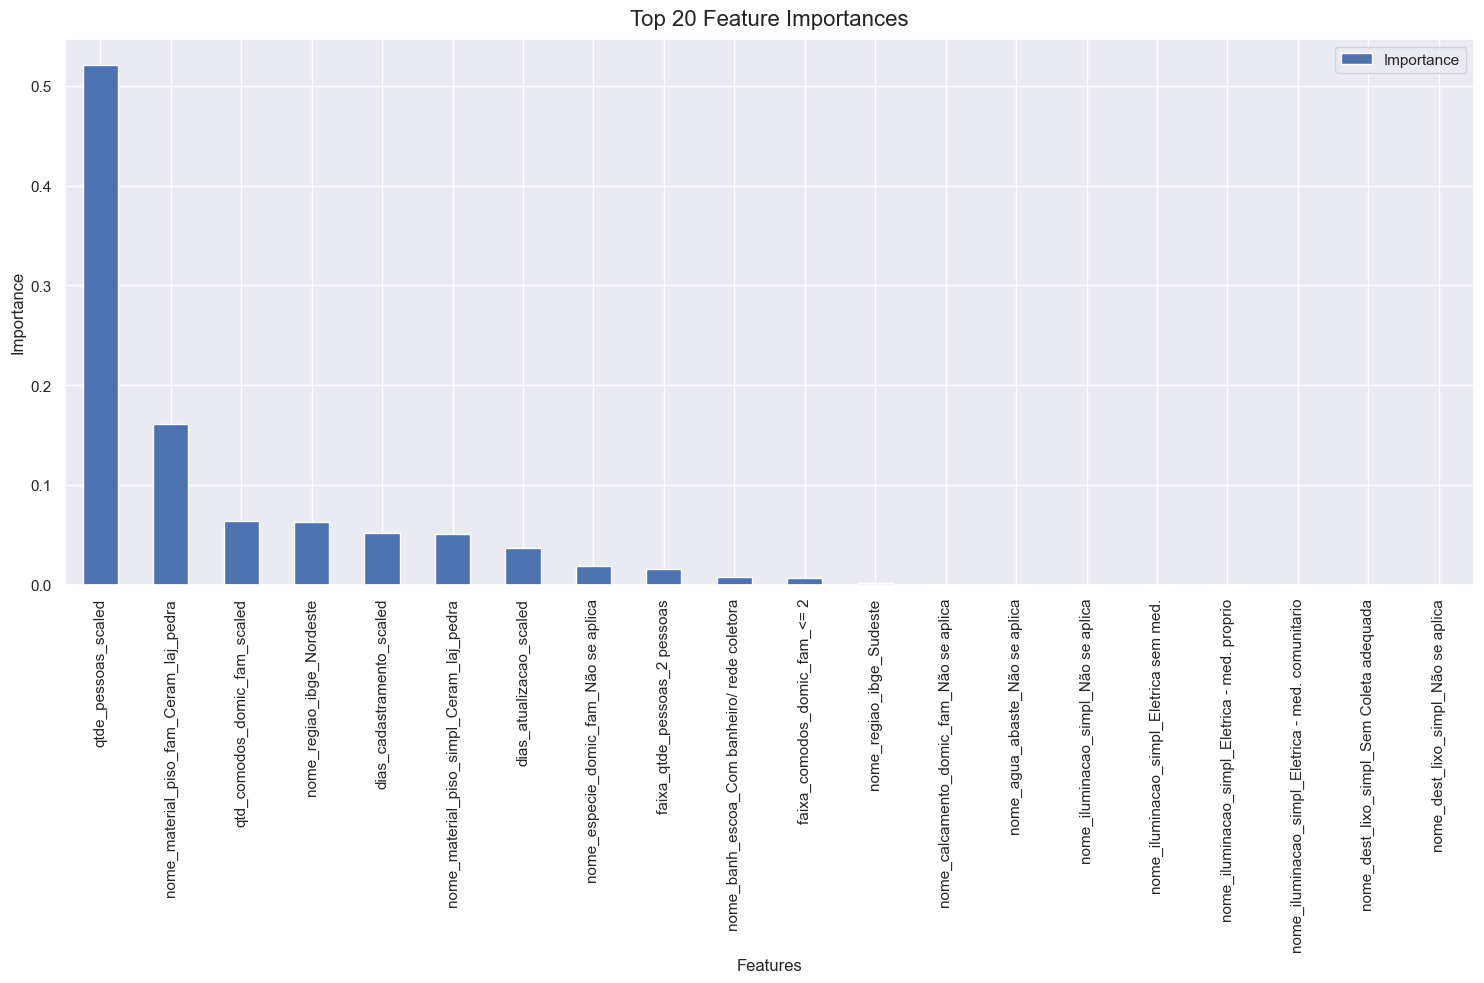

In [886]:
top_10_var_predictors = get_feature_importances_RF(model, X)

## Salvar na planilha de metricas

In [ ]:
result = {
    'model_name': model_name,
    'learning_rate': 'na',
    'loss_function':'na',
    'test_size': test_size,
    'depth': 'na',
    'random_seed': random_seed,
    'accuracy': acc_score, 
    'm_precision': rpt_macro_avg['precision'], 
    'm_recall': rpt_macro_avg['recall'], 
    'm_f1_score': rpt_macro_avg['f1-score'],
    'w_precision': rpt_weighted_avg['precision'], 
    'w_recall': rpt_weighted_avg['recall'], 
    'w_f1_score': rpt_weighted_avg['f1-score'],
    'var_predictors': var_predictors,
    'top_10_var_predictors':top_10_var_predictors,
    'details': details,
    'param':params}

df_metrics = pd.concat([df_metrics, pd.DataFrame([result])], ignore_index=True)

In [889]:
col_int = ['model_name', 'test_size', 'random_seed',
           'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details', 'param']
#col_int = ['accuracy', 'top_10_var_predictors'] 

df_metrics[df_metrics['model_name']=='Decision Tree'][col_int]\
            .sort_values(by='accuracy', ascending=False)

,model_name,test_size,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details,param
20,Decision Tree,0.2000,42,0.6411,0.5634,0.4853,0.4707,0.6001,0.6411,0.5798,"Todas variaveis, inclusive UF","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}"
23,Decision Tree,0.2000,42,0.6411,0.5634,0.4853,0.4707,0.6001,0.6411,0.5798,"Todas variaveis, exceto UF","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}"
24,Decision Tree,0.2000,42,0.6411,0.5634,0.4853,0.4707,0.6001,0.6411,0.5798,"Todas variaveis, exceto UF e grupos especificos","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}"
21,Decision Tree,0.2000,42,0.6378,0.5505,0.4856,0.4665,0.5920,0.6378,0.5759,"Todas variaveis, inclusive UF","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}"
22,Decision Tree,0.2000,42,0.6378,0.5505,0.4856,0.4665,0.5920,0.6378,0.5759,"Todas variaveis, inclusive UF","{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}"


In [891]:
#df_metrics.to_csv('./dados_metricas/df_metrics_domicilio.csv', encoding='UTF-8',  sep='|',  index=False)

# XGBoost

## Parametros

In [1063]:
model_name='XGBoost'
test_size=0.2
random_seed=42
eval_metric= 'mlogloss' # ['merror','aucpr','mlogloss']# 'merror'
objective='multi:softmax'
n_estimators = 500
max_depth=5
learning_rate=0.01
details='Todas variaveis, inclusive UF' 

## Setar variaveis preditoras e target 

In [965]:
lista_nomes_encoded_2 = df_fam.columns[88:].values
#lista_nomes_encoded_2

In [966]:
var_predictors='l_col_num_scaled, lista_nomes_encoded_2'

X = pd.concat([
        df_fam[l_col_num_scaled],
        df_fam[lista_nomes_encoded_2],
        ], axis=1) 
y = df_fam['classe_renda']

In [967]:
# para XGBoost não pode ter caracteres especiais nos nomes das colunas
X.columns = ['qtd_comodos_domic_fam_scaled'
,'qtd_comodos_dormitorio_fam_scaled'
,'dias_cadastramento_scaled'
,'dias_atualizacao_scaled'
,'qtde_pessoas_scaled'
,'nome_uf_ibge_AC','nome_uf_ibge_AL'
,'nome_uf_ibge_AM','nome_uf_ibge_AP','nome_uf_ibge_BA','nome_uf_ibge_CE'
,'nome_uf_ibge_DF','nome_uf_ibge_ES','nome_uf_ibge_GO','nome_uf_ibge_MA'
,'nome_uf_ibge_MG','nome_uf_ibge_MS','nome_uf_ibge_MT','nome_uf_ibge_PA'
,'nome_uf_ibge_PB','nome_uf_ibge_PE','nome_uf_ibge_PI','nome_uf_ibge_PR'
,'nome_uf_ibge_RJ','nome_uf_ibge_RN','nome_uf_ibge_RO','nome_uf_ibge_RR'
,'nome_uf_ibge_RS','nome_uf_ibge_SC','nome_uf_ibge_SE','nome_uf_ibge_SP'
,'nome_uf_ibge_TO','nome_regiao_ibge_Centro-Oeste'
,'nome_regiao_ibge_Nordeste'
,'nome_regiao_ibge_Norte'
,'nome_regiao_ibge_Sudeste'
,'nome_regiao_ibge_Sul'
,'nome_classf_Capital'
,'nome_classf_Outros', 'nome_classf_Regiao Metrop'
,'nome_local_domic_fam_Nao se aplica', 'nome_local_domic_fam_Rurais'
,'nome_local_domic_fam_Urbanas', 'nome_especie_domic_fam_Coletivo'
,'nome_especie_domic_fam_Nao se aplica'
,'nome_especie_domic_fam_Particular Permanente'
,'nome_especie_domic_fam_Particular improvisado'
,'nome_material_piso_fam_Carpete', 'nome_material_piso_fam_Ceram_laj_pedra'
,'nome_material_piso_fam_Cimento', 'nome_material_piso_fam_Madeira_apar'
,'nome_material_piso_fam_Madeira_aprov'
,'nome_material_piso_fam_Nao se aplica', 'nome_material_piso_fam_Outro'
,'nome_material_piso_fam_Terra'
,'nome_material_domic_fam_Alvenaria_tijolo com revestimento'
,'nome_material_domic_fam_Alvenaria_tijolo sem revestimento'
,'nome_material_domic_fam_Madeira aparelhada'
,'nome_material_domic_fam_Madeira aproveitada'
,'nome_material_domic_fam_Nao se aplica'
,'nome_material_domic_fam_Outro Material', 'nome_material_domic_fam_Palha'
,'nome_material_domic_fam_Taipa nao revestida'
,'nome_material_domic_fam_Taipa revestida'
,'nome_agua_canalizada_fam_Nao se aplica'
,'nome_agua_canalizada_fam_Nao tem agua canalizada'
,'nome_agua_canalizada_fam_Tem agua canalizada'
,'nome_abaste_agua_domic_fam_Cisterna'
,'nome_abaste_agua_domic_fam_Nao se aplica'
,'nome_abaste_agua_domic_fam_Outros'
,'nome_abaste_agua_domic_fam_Poço_Nascente'
,'nome_abaste_agua_domic_fam_Rede distribuiçao'
,'nome_banheiro_domic_fam_Com banheiro'
,'nome_banheiro_domic_fam_Nao se aplica'
,'nome_banheiro_domic_fam_Sem banheiro'
,'nome_escoa_sanitario_domic_fam_Direto para rio_mar'
,'nome_escoa_sanitario_domic_fam_Fossa rudimentar'
,'nome_escoa_sanitario_domic_fam_Fossa septica'
,'nome_escoa_sanitario_domic_fam_Nao se aplica'
,'nome_escoa_sanitario_domic_fam_Outro'
,'nome_escoa_sanitario_domic_fam_Rede coletora de esgoto_pluvial'
,'nome_escoa_sanitario_domic_fam_Vala a ceu aberto'
,'nome_destino_lixo_domic_fam_Coletado diretamente'
,'nome_destino_lixo_domic_fam_Coletado indiretamente'
,'nome_destino_lixo_domic_fam_Jogado em rio_mar'
,'nome_destino_lixo_domic_fam_Jogado em terreno baldio_logradouro'
,'nome_destino_lixo_domic_fam_Nao se aplica'
,'nome_destino_lixo_domic_fam_Outro destino'
,'nome_destino_lixo_domic_fam_Queimado_enterrado na propriedade'
,'nome_iluminacao_domic_fam_Eletrica - med. comunitario'
,'nome_iluminacao_domic_fam_Eletrica - med. proprio'
,'nome_iluminacao_domic_fam_Eletrica sem med.'
,'nome_iluminacao_domic_fam_Nao se aplica'
,'nome_iluminacao_domic_fam_Oleo_querosene_gas'
,'nome_iluminacao_domic_fam_Outra forma', 'nome_iluminacao_domic_fam_Vela'
,'nome_calcamento_domic_fam_Nao existe'
,'nome_calcamento_domic_fam_Nao se aplica'
,'nome_calcamento_domic_fam_Parcial', 'nome_calcamento_domic_fam_Total'
,'estrato_1', 'estrato_2', 'cod_familia_indigena_fam_1'
,'cod_familia_indigena_fam_2', 'ind_familia_quilombola_fam_1'
,'ind_familia_quilombola_fam_2', 'ind_parc_mds_fam_0'
,'ind_parc_mds_fam_101', 'ind_parc_mds_fam_201', 'ind_parc_mds_fam_202'
,'ind_parc_mds_fam_203', 'ind_parc_mds_fam_204', 'ind_parc_mds_fam_205'
,'ind_parc_mds_fam_301', 'ind_parc_mds_fam_302', 'ind_parc_mds_fam_303'
,'ind_parc_mds_fam_304', 'ind_parc_mds_fam_305', 'ind_parc_mds_fam_306'
,'ind_parc_mds_fam_9'
,'nome_banh_escoa_Com banheiro_escoamento inadequado'
,'nome_banh_escoa_Com banheiro_fossa rudimentar'
,'nome_banh_escoa_Com banheiro_fossa septica'
,'nome_banh_escoa_Com banheiro_rede coletora'
,'nome_banh_escoa_Sem banheiro'
,'nome_agua_abaste_Com agua canalizada_Poço_cisterna_outros'
,'nome_agua_abaste_Com agua canalizada_Rede distrib.'
,'nome_agua_abaste_Nao se aplica'
,'nome_agua_abaste_Sem agua canalizada_Poço_cisterna_outros'
,'nome_agua_abaste_Sem agua canalizada_Rede distrib.'
,'nome_dest_lixo_simpl_Coletado diretamente'
,'nome_dest_lixo_simpl_Coletado indiretamente'
,'nome_dest_lixo_simpl_Nao se aplica'
,'nome_dest_lixo_simpl_Sem Coleta adequada'
,'nome_iluminacao_simpl_Eletrica - med. comunitario'
,'nome_iluminacao_simpl_Eletrica - med. proprio'
,'nome_iluminacao_simpl_Eletrica sem med.'
,'nome_iluminacao_simpl_Nao se aplica'
,'nome_iluminacao_simpl_Sem eletricidade'
,'nome_material_piso_simpl_Ceram_laj_pedra'
,'nome_material_piso_simpl_Cimento'
,'nome_material_piso_simpl_Nao se aplica', 'nome_material_piso_simpl_Outro'
,'nome_material_piso_simpl_Terra'
,'nome_material_domic_simpl_Alvenaria_tijolo com revestimento'
,'nome_material_domic_simpl_Alvenaria_tijolo sem revestimento'
,'nome_material_domic_simpl_Madeira aparelhada'
,'nome_material_domic_simpl_Nao se aplica'
,'nome_material_domic_simpl_Outro Material', 'ind_grp_especifico_Nao'
,'ind_grp_especifico_Sim', 'ind_grp_especial_Nao', 'ind_grp_especial_Sim'
,'faixa_comodos_domic_fam_3', 'faixa_comodos_domic_fam_4'
,'faixa_comodos_domic_fam_5', 'faixa_comodos_domic_fam_menor_igual_2'
,'faixa_comodos_domic_fam_maior_igual_6', 'faixa_comodos_domic_fam_Nao se aplica'
,'faixa_comodos_dormitorio_fam_maior_igual_3'
,'faixa_comodos_dormitorio_fam_Apenas 1'
,'faixa_comodos_dormitorio_fam_Apenas 2'
,'faixa_comodos_dormitorio_fam_Nenhum'
,'faixa_comodos_dormitorio_fam_Nao se aplica'
,'faixa_qtde_pessoas_1 pessoa', 'faixa_qtde_pessoas_2 pessoas'
,'faixa_qtde_pessoas_3 pessoas', 'faixa_qtde_pessoas_maior_igual_4 pessoas']

## Dividir os dados em conjuntos de treino e teste

In [1064]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_seed)

## Treinar o modelo

In [1065]:
model = xgb.XGBClassifier(
    objective=objective, 
    learning_rate= learning_rate,
    num_class=3, 
    eval_metric=eval_metric,
    n_estimators=n_estimators,
    max_depth=max_depth,
    use_label_encoder=True,
    verbose=True)

In [1066]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [1067]:
params = model.get_params()

## Avaliar o modelo

### Classification Report

In [1068]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# Extrair as métricas 
rpt_accuracy = report['accuracy']
rpt_macro_avg = report['macro avg']
rpt_weighted_avg = report['weighted avg']

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6608983990466816
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.89      0.78     11424
           1       0.47      0.12      0.20      4090
           2       0.59      0.55      0.57      3787

    accuracy                           0.66     19301
   macro avg       0.59      0.52      0.51     19301
weighted avg       0.63      0.66      0.61     19301



### Matriz Confusão

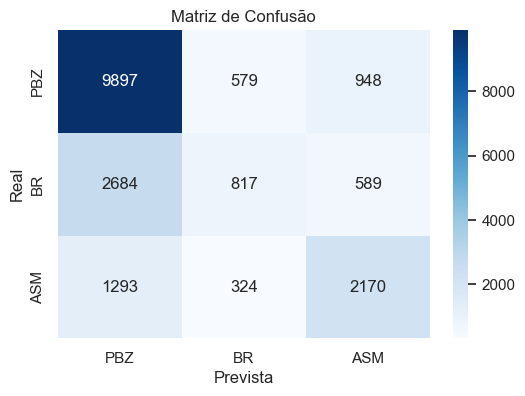

In [952]:
create_confusion_matrix(y_test, y_pred)

### Features mais importantes

,Feature,Importance
48,nome_material_piso_fam_Ceram_laj_pedra,0.1083
4,qtde_pessoas_scaled,0.0893
33,nome_regiao_ibge_Nordeste,0.0450
99,nome_calcamento_domic_fam_Total,0.0345
40,nome_local_domic_fam_Nao se aplica,0.0281
0,qtd_comodos_domic_fam_scaled,0.0233
90,nome_iluminacao_domic_fam_Eletrica - med. proprio,0.0228
42,nome_local_domic_fam_Urbanas,0.0209
35,nome_regiao_ibge_Sudeste,0.0175
23,nome_uf_ibge_RJ,0.0156


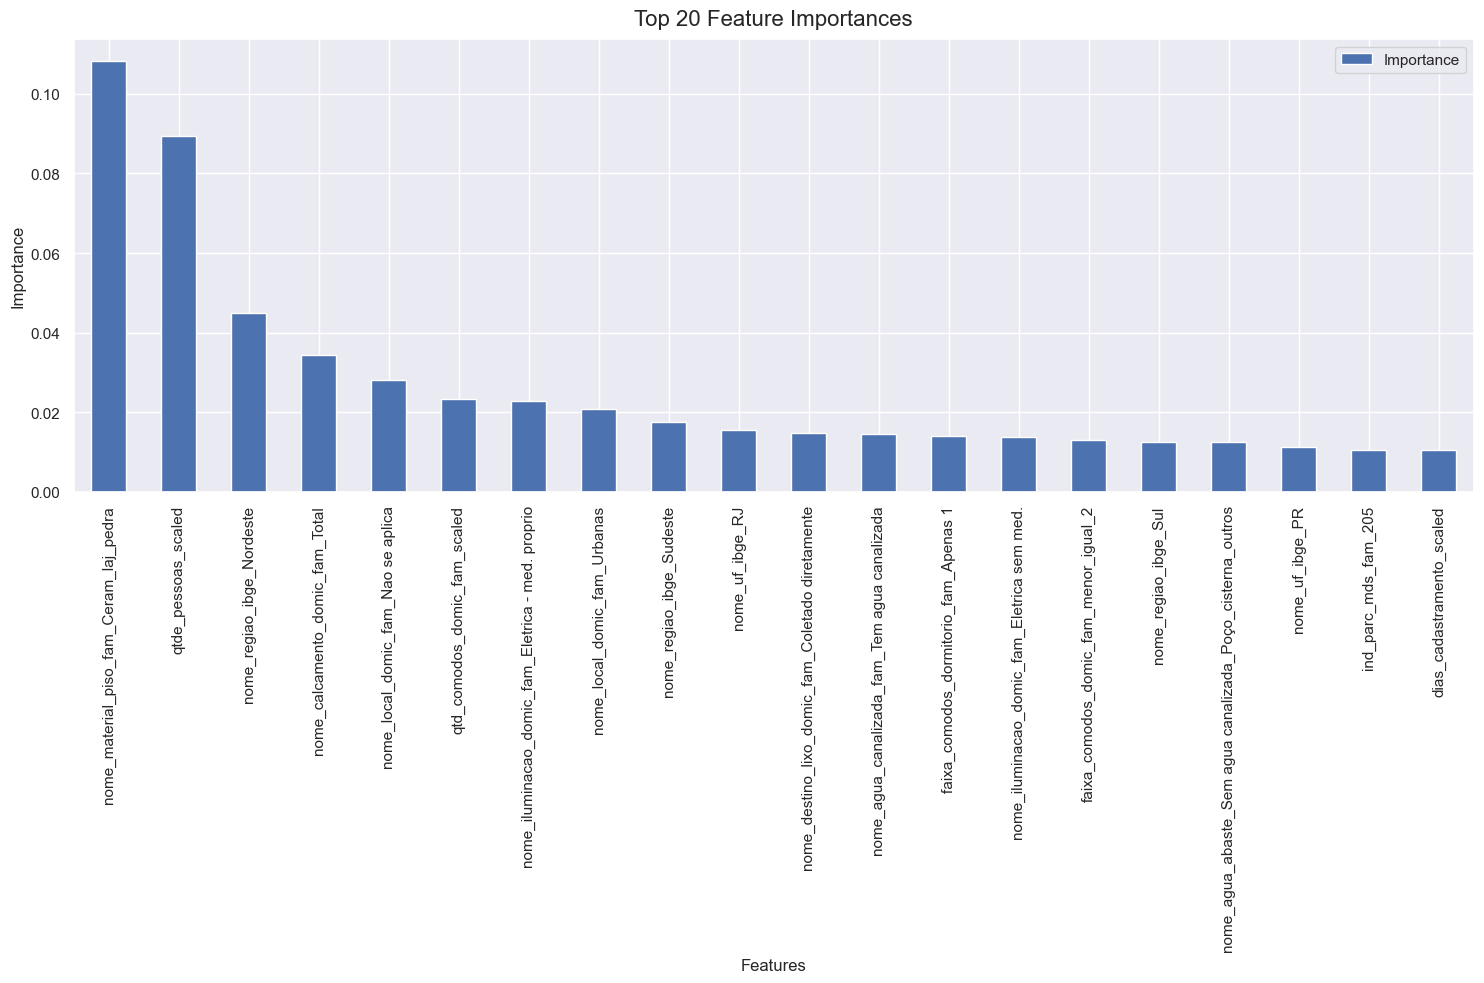

In [1059]:
top_10_var_predictors = get_feature_importances_RF(model, X)

## Salvar na planilha de metricas

In [ ]:
result = {
    'model_name': model_name,
    'learning_rate': 'na',
    'loss_function':'na',
    'test_size': test_size,
    'depth': 'na',
    'random_seed': random_seed,
    'accuracy': acc_score, 
    'm_precision': rpt_macro_avg['precision'], 
    'm_recall': rpt_macro_avg['recall'], 
    'm_f1_score': rpt_macro_avg['f1-score'],
    'w_precision': rpt_weighted_avg['precision'], 
    'w_recall': rpt_weighted_avg['recall'], 
    'w_f1_score': rpt_weighted_avg['f1-score'],
    'var_predictors': var_predictors,
    'top_10_var_predictors':top_10_var_predictors,
    'details': details,
    'param':params}

df_metrics = pd.concat([df_metrics, pd.DataFrame([result])], ignore_index=True)

In [1069]:
col_int = ['model_name', 'test_size', 'random_seed',
           'accuracy', 'm_precision', 'm_recall', 'm_f1_score',
           'w_precision', 'w_recall', 'w_f1_score', 'details', ] 
#col_int = ['accuracy', 'top_10_var_predictors'] 

df_metrics[df_metrics['model_name']=='XGBoost'][col_int]\
            .sort_values(by='accuracy', ascending=False)

,model_name,test_size,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,details
28,XGBoost,0.2000,42,0.6674,0.5928,0.5430,0.5432,0.6371,0.6674,0.6334,"Todas variaveis, inclusive UF"
25,XGBoost,0.2000,42,0.6658,0.5878,0.5457,0.5473,0.6358,0.6658,0.6357,"Todas variaveis, inclusive UF"
26,XGBoost,0.2000,42,0.6642,0.5845,0.5477,0.5501,0.6350,0.6642,0.6371,"Todas variaveis, inclusive UF"
27,XGBoost,0.2000,42,0.6642,0.5845,0.5477,0.5501,0.6350,0.6642,0.6371,"Todas variaveis, inclusive UF"


In [1071]:
df_metrics.shape

(29, 17)

In [1070]:
#df_metrics.to_csv('./dados_metricas/df_metrics_domicilio.csv', encoding='UTF-8',  sep='|',  index=False)